### Loading packages

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import warnings
import openpyxl


In [77]:
warnings.filterwarnings('ignore')

In [4]:
costs = pd.read_excel('/Users/leox_50/Desktop/KSE/Job preparation/AMO/task3_data.xlsx', sheet_name= 'Costs by source')
users = pd.read_excel('/Users/leox_50/Desktop/KSE/Job preparation/AMO/task3_data.xlsx', sheet_name= 'Users')
orders = pd.read_excel('/Users/leox_50/Desktop/KSE/Job preparation/AMO/task3_data.xlsx', sheet_name= 'Orders')

In [8]:
def data_analysis(data):

    return ProfileReport(data)

In [76]:
data_analysis(costs)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Description

- 1. На основі «task3_data.xlsx» розрахувати ROI:
    - нульового дня, 
    - першого тижня, 
    - першого місяця для різних джерел трафіку в різних місяцях.
   
Основне питання - що рентабельне, а що - збиткове. 

- 2. Також побудувати графік Cost per Registration для різних джерелах трафіку по дням.  



In [ ]:
### in this case, roi is revenue / cost. The cohort anaylsis will help to answer the question.

In [18]:
# there are no retained users, or at least the method of hashing the user id never produces the same user_id

users['id'].unique().size / users.shape[0] 

1.0

In [24]:
costs['date'] = pd.to_datetime(costs['date'])
users['date_created'] = pd.to_datetime(users['date_created'])
orders['date_ordered'] = pd.to_datetime(orders['date_order'])

In [176]:
def registrations_in_time(traffic_source):

    users_df = users[users['source'] == traffic_source]
    users_df['month'] = users_df['date_created'].dt.month

    users_df = users_df[['month','id']].groupby('month').nunique().reset_index().rename(columns = {'id':'number_of_registrations'})
    users_df['traffic_source'] = traffic_source

    return users_df

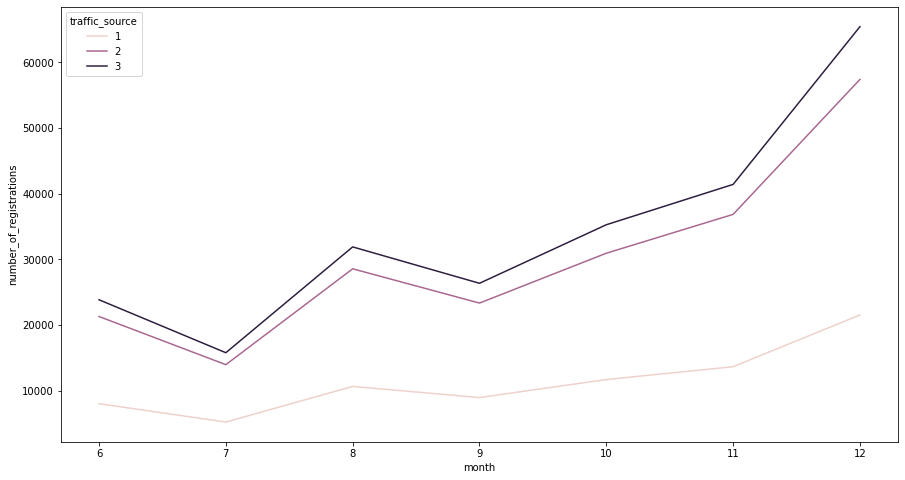

In [230]:
data_for_chart = pd.concat([registrations_in_time(1), registrations_in_time(2),registrations_in_time(3)]).reset_index(drop=True)

plt.figure(figsize=(15,8))
sns.lineplot(data = data_for_chart, x  = 'month', y = 'number_of_registrations', hue = 'traffic_source')
plt.show()

### The graph shows that the spend is not equally distributed across the traffic sources. Most probably, this is the business decision, that we should account for.

In [144]:
def cohorts(traffic_source: str, longevity: str):

    #filtering by traffic source

    users_df = users[users['source'] == traffic_source]
    users_df['month'] = users_df['date_created'].dt.month

    #creating registration cohorts

    cohorts_acc_creations = users_df[['month','id']].groupby('month').nunique().reset_index()

    longevity_diff = longevity + '_difference'

    cohorts_table = pd.DataFrame({longevity_diff: [], 'cohort_revenue': [], 'month':[]})

    #creating cohorts by month in rows. The longveity (distance in time from registration date) in columns is selected in the parameter

    for month in cohorts_acc_creations['month'].unique():

      month_users = users_df[users_df['month'] == month][['id','date_created']]
      orders_month = orders[orders['id_user'].isin(month_users['id'].unique())].rename(columns = {'id':'order_id','id_user':'id'})

      orders_users = pd.merge(orders_month, month_users, how = 'left', on = 'id')

      if longevity == 'month':

        orders_users[longevity_diff] = (orders_users['date_order'] - orders_users['date_created']) / np.timedelta64(1,'M')
        orders_users[longevity_diff] = orders_users[longevity_diff].astype(int)

      elif longevity == 'week':

        orders_users[longevity_diff] = (orders_users['date_order'] - orders_users['date_created']) / np.timedelta64(1,'W')
        orders_users[longevity_diff] = orders_users[longevity_diff].astype(int)

      elif longevity == 'day':

        orders_users[longevity_diff] = (orders_users['date_order'] - orders_users['date_created']).dt.days
        orders_users[longevity_diff] = orders_users[longevity_diff].astype(int)

      cohort_orders = orders_users[[longevity_diff, 'amount']].groupby(longevity_diff).sum().reset_index().rename(columns={'amount':'cohort_revenue'})
      cohort_orders['month'] = month

      cohorts_table = pd.concat([cohorts_table,cohort_orders])

    cohorts_table = cohorts_table.pivot_table(index= 'month', columns=longevity_diff, values = ['cohort_revenue']).fillna(0)

    costs_df = costs[costs['source'] == traffic_source]
    costs_df['month'] = costs_df['date'].dt.month

    costs_cohorts = costs_df[['month','cost']].groupby('month').sum().reset_index()

    cohorts_formatted = pd.DataFrame(cohorts_table.loc[:,('cohort_revenue',0)]).reset_index()
    cohorts_formatted.columns = cohorts_formatted.columns.droplevel(1)

    final_df = pd.merge(cohorts_formatted, costs_cohorts, on = 'month',how="inner")
    final_df['ROI'] = round(final_df['cohort_revenue'] / final_df['cost'],2) 

    return final_df
    

In [232]:
cohorts(2, longevity='month')

,month,cohort_revenue,cost,ROI
0,6.0,57369.58,116367.509255,0.49
1,7.0,41651.49,128836.761092,0.32
2,8.0,59505.28,128915.377080,0.46
3,9.0,55781.99,119563.491479,0.47
4,10.0,59708.33,119677.076892,0.50
5,11.0,72153.73,121105.371484,0.60
6,12.0,146341.19,124677.692760,1.17


In [270]:
cohorts(1, longevity='month')

,month,cohort_revenue,cost,ROI
0,6.0,25630.19,82202.879305,0.31
1,7.0,13309.95,88583.274443,0.15
2,8.0,28231.17,95448.341997,0.30
3,9.0,20687.13,89822.298643,0.23
4,10.0,34441.34,91960.839996,0.37
5,11.0,31893.96,83878.798991,0.38
6,12.0,48895.03,91198.043586,0.54


In [271]:
cohorts(3, longevity='month')

,month,cohort_revenue,cost,ROI
0,6.0,44058.14,225569.350040,0.20
1,7.0,35713.59,233821.702244,0.15
2,8.0,76523.57,242213.096086,0.32
3,9.0,69849.82,218727.526098,0.32
4,10.0,67381.45,233747.487383,0.29
5,11.0,102199.72,229766.869291,0.44
6,12.0,122409.58,224496.836219,0.55


#### Final Comments:

Some points: 
- Would be good to understand the wacc and the stage of the start-up. For example, in the beginning we could expect a lower CAC, as with time this metric growth due to traffic exhaustion.
- To answer the question of profitability, we also should look at LTV and its ration with CAC. Having more time, I would calculate it as Lifetime * ARPU per cohort. Lifetime would be calculated as Area under the curve of retention rate through taking an integral of the function of the curve. 
- Looking only at the metrics above, the second traffic source looks the most attractable, as for the most recent cohorts on the monthly time range ROI becomes positive. However, the more time went from the acquisition, the higher the ROI will be.

### 3. Також побудувати графік Cost per Registration для різних джерелах трафіку по дням. 

In [ ]:
### evaluating the CPR is not enough to capture the all trends. Having these data, I also propose to look at CPA, as it will also indicate about different traffic sources performance.

In [207]:
def cost_per_day(traffic_source, metric:str):

    #metrics are nubmer of registrations and number of orders
    
    costs_df = costs[costs['source'] == traffic_source]
    costs_df['date'] = costs_df['date'].dt.date

    costs_cohorts = costs_df[['date','cost']].groupby('date').sum().reset_index()

    users_df = users[users['source'] == traffic_source]
    users_df['date'] = users_df['date_created'].dt.date

    users_cohors = users_df[['date','id']].groupby('date').nunique().reset_index().rename(columns= {'id':'number_of_registrations'})

    if metric == 'CPR':

        df_metric = pd.merge(users_cohors, costs_cohorts,on = 'date', how='inner')
        df_metric['CPR'] = df_metric['cost'] / df_metric['number_of_registrations']
    
    elif metric == 'CPA':

        first_orders = orders[orders['id_user'].isin(users_df['id'])][['id_user','date_order']].groupby('id_user').min().reset_index().rename(columns={'id_user':'id'})
        users_orders = pd.merge(users_df,first_orders, on = 'id', how = 'inner')
        df_metric = users_orders[['date','id']].groupby('date').nunique().reset_index().rename(columns= {'id':'number_of_orders'})
        df_metric = pd.merge(costs_cohorts,df_metric, on = 'date', how = 'left').fillna(0)
        df_metric['CPA'] = df_metric['cost'] / df_metric['number_of_orders']

    elif metric == 'Action Rate':

        first_orders = orders[orders['id_user'].isin(users_df['id'])][['id_user','date_order']].groupby('id_user').min().reset_index().rename(columns={'id_user':'id'})
        users_orders = pd.merge(users_df,first_orders, on = 'id', how = 'inner')
        df_metric = users_orders[['date','id']].groupby('date').nunique().reset_index().rename(columns= {'id':'number_of_orders'})
        df_metric = pd.merge(users_cohors,df_metric, on = 'date', how = 'left').fillna(0)
        df_metric['Action Rate'] = df_metric['number_of_orders'] / df_metric['number_of_registrations']
        
    return df_metric

In [237]:
def plot_metric(traffic_source, metric, axes):

    plt.figure(figsize=(15,8))

    sns.lineplot(data = cost_per_day(traffic_source, metric), x = 'date', y = metric, ax=axes)

    plt.title(f"{metric} in time for {traffic_source} traffic source")
    plt.show()

In [265]:
def plot_metric(metric):

    fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharey=True)
    fig.suptitle(f'{metric} for all traffic sources')

    sns.lineplot(data = cost_per_day(1, metric), x = 'date', y = metric, ax=axes[0], linewidth=2.5)
    axes[0].set_title(f"{metric} in time for {1} traffic source")

    sns.lineplot(data = cost_per_day(2, metric), x = 'date', y = metric, ax=axes[1], color='#CB482C', linewidth=2.5)
    axes[1].set_title(f"{metric} in time for {2} traffic source")
    
    sns.lineplot(data = cost_per_day(3, metric), x = 'date', y = metric, ax=axes[2], color='#1BBF81', linewidth=2.5)
    axes[2].set_title(f"{metric} in time for {3} traffic source")

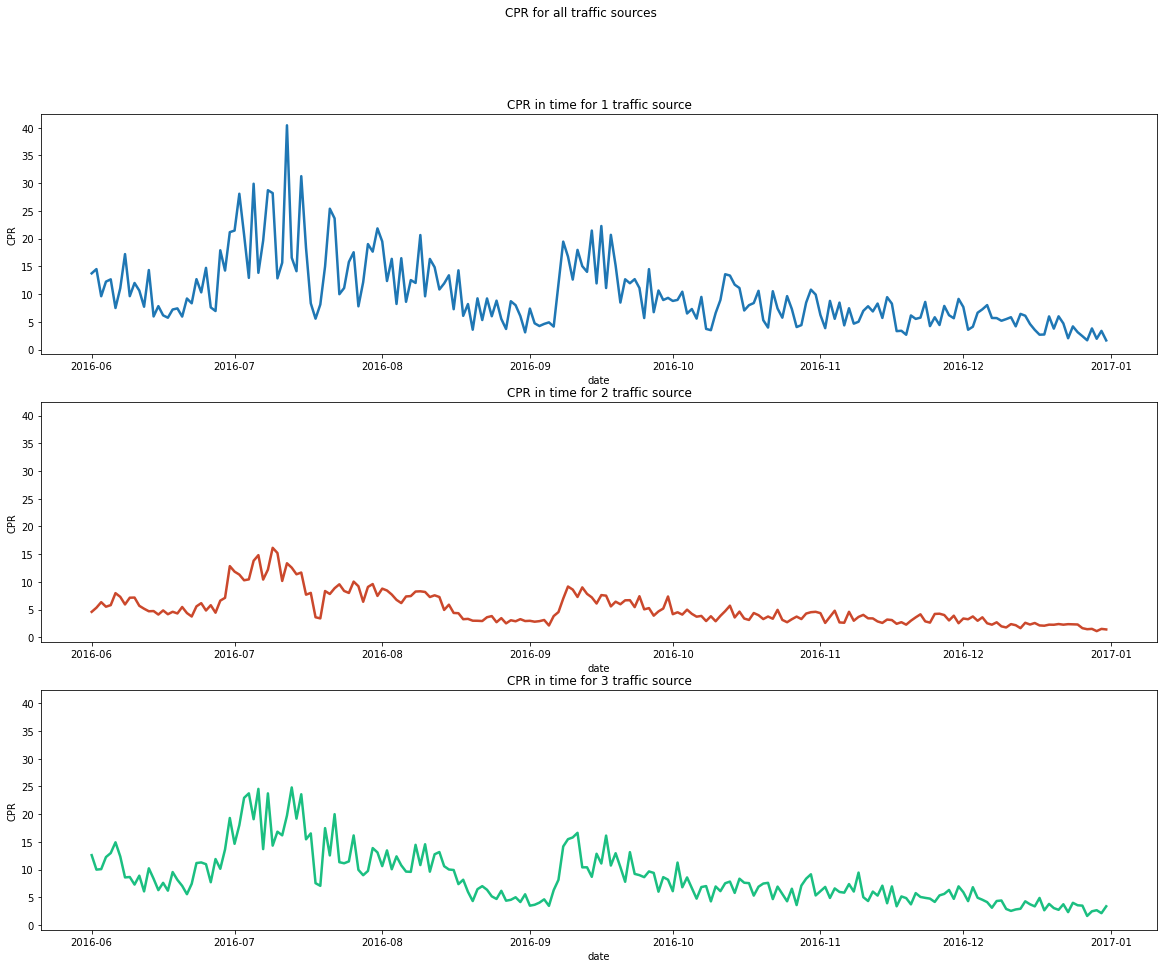

In [269]:
plot_metric('CPR')

In [229]:
for i in range(1,4):

    print(f"Weighted CPA for {i} traffic source is: ${round(cost_per_day(i, 'CPA')['cost'].sum() / cost_per_day(i, 'CPA')['number_of_orders'].sum(),2)}")
    print(f"Weighted CPR for {i} traffic source is: ${round(cost_per_day(i, 'CPR')['cost'].sum() / cost_per_day(i, 'CPR')['number_of_registrations'].sum(), 2)}")
    print(f"Average Action Rate for {i} traffic source is: {round(cost_per_day(i, 'Action Rate')['number_of_orders'].sum() / cost_per_day(i, 'Action Rate')['number_of_registrations'].sum() * 100,2)}%")


Weighted CPA for 1 traffic source is: $438.49
Weighted CPR for 1 traffic source is: $7.8
Average Action Rate for 1 traffic source is: 1.78%
Weighted CPA for 2 traffic source is: $214.68
Weighted CPR for 2 traffic source is: $4.04
Average Action Rate for 2 traffic source is: 1.88%
Weighted CPA for 3 traffic source is: $386.25
Weighted CPR for 3 traffic source is: $6.7
Average Action Rate for 3 traffic source is: 1.73%


## Final recommendations:

even though the metrics are super high in terms of CPA and super low action rate. Usually, while having such high values, we expect to see high LTV to cover the costs. Talking about the ROI, it is in plus only once, for traffic source #2 and only for the 12th month, which is also typicall for businesses with high-low seasons separations.

The results above show significat difference in metrics for different acquisition channels. It makes sense, because different channels have different audience. For example, TikTok usually has a higher share of U21 users compared to Facebook. However, age is a very strong predictor in terms of purchasing power of users, so older users usually pay more than young users.

